In [1]:
# load the modules

from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data

train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# preparation data

train_label = train[:, 0]
train_data = np.delete(train, train[:, 0], axis=1)

train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

X_train_img = train_img.reshape(-1, 28 * 28).astype(np.float32)
X_test_img = test_img.reshape(-1, 28 * 28).astype(np.float32)

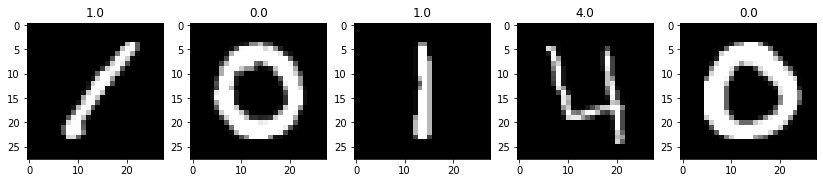

In [4]:
# plot some of the numbers

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

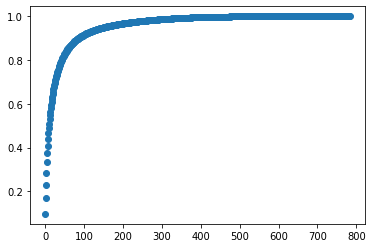

In [5]:
# preparation data for PCA

X_mean = X_train_img.mean(axis=0)
X_train_img -= X_mean

cov = np.dot(X_train_img.T, X_train_img) / X_train_img.shape[0]
U, S, _ = np.linalg.svd(cov)
S_cumsum = np.cumsum(S) / np.sum(S)

plt.plot(S_cumsum, 'o');

In [6]:
S_thr = 0.95

n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=153 S=0.950


In [7]:
# reduced data

X_train_reduced = np.dot(X_train_img, U[:, :n_comp])
X_test_reduced = np.dot(X_test_img, U[:, :n_comp])

In [8]:
# split data on some parts

X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, train_label, test_size=0.2, random_state=42)
X_train, X_values, y_train, y_values = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [9]:
# using kNN and simple finding best params

accuracies = {}

for k in range(1, 20):
    for p in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors=k, p=p, n_jobs=-1)
        knn.fit(X_train, y_train)

        score = knn.score(X_values, y_values)
        accuracies[score] = [k, p]
    
print('\nBest accuracy: %.2f%%\nBest params: k=%d, p=%d' % (max(accuracies)*100, 
                                                     accuracies[max(accuracies, key=float)][0], 
                                                     accuracies[max(accuracies, key=float)][1]))


Best accuracy: 97.05%
Best params: k=6, p=3


In [10]:
# kNN classification report

knn = KNeighborsClassifier(n_neighbors=accuracies[max(accuracies, key=float)][0],
                           p=accuracies[max(accuracies, key=float)][1],
                           n_jobs=-1)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

print('\t\tClassification report with k=%d, p=%d\n' % (accuracies[max(accuracies, key=float)][0],
                                                         accuracies[max(accuracies, key=float)][1]))
print(classification_report(y_test, y_predict))

		Classification report with k=6, p=3

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       816
         1.0       0.95      1.00      0.97       909
         2.0       0.98      0.96      0.97       846
         3.0       0.96      0.96      0.96       937
         4.0       0.98      0.96      0.97       839
         5.0       0.95      0.96      0.96       702
         6.0       0.97      0.98      0.98       785
         7.0       0.96      0.96      0.96       893
         8.0       0.98      0.93      0.96       835
         9.0       0.95      0.95      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [11]:
# fit-predict

knn = KNeighborsClassifier(n_neighbors=accuracies[max(accuracies, key=float)][0],
                           p=accuracies[max(accuracies, key=float)][1],
                           n_jobs=-1)
knn.fit(X_train_reduced, train_label)
prediction = knn.predict(X_test_reduced)

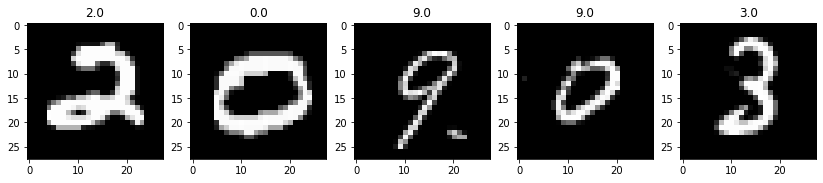

In [12]:
# prediction

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % prediction[i - 1]);

In [13]:
# save result

with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(prediction, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [14]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,9
7,0
8,3
9,0
